In [48]:
import pandas as pd
import xgboost as xgb
import numpy as np
import datetime as dt
import random
from sportsreference.ncaab.teams import Teams
from sklearn.preprocessing import scale
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 100)

In [4]:
teams_df = pd.DataFrame()
i = 2010
while i <=2019:
    print("Downloading data for the", i, "season.")
    start = dt.datetime.now()
    teams = Teams(year = i)
    end = dt.datetime.now()
    teams_temp = teams.dataframes
    teams_temp['Season'] = i
    teams_df = pd.concat([teams_df, teams_temp])
    span = end - start
    print(i, "took", span, "seconds to download.")
    i += 1

2010 took 0:00:20.515166 seconds to download.
2011 took 0:00:20.536113 seconds to download.
2012 took 0:00:20.277801 seconds to download.
2013 took 0:00:20.556057 seconds to download.
2014 took 0:00:20.619887 seconds to download.
2015 took 0:00:20.638837 seconds to download.
2016 took 0:00:20.265835 seconds to download.
2017 took 0:00:20.450341 seconds to download.
2018 took 0:00:21.563367 seconds to download.
2019 took 0:00:22.422071 seconds to download.


In [6]:
teams_df.head()

,abbreviation,assist_percentage,assists,away_losses,away_wins,block_percentage,blocks,conference,conference_losses,conference_wins,...,two_point_field_goal_percentage,two_point_field_goals,total_rebound_percentage,total_rebounds,true_shooting_percentage,turnover_percentage,turnovers,win_percentage,wins,Season
AIR-FORCE,AIR-FORCE,61.6,389,10,0,6.2,51,mwc,15,1,...,0.527,456,46.8,851,0.529,19.0,394,0.323,10,2010
AKRON,AKRON,53.9,473,4,7,8.5,114,mac,4,12,...,0.483,642,51.6,1269,0.521,16.4,464,0.686,24,2010
ALABAMA-AM,ALABAMA-AM,48.1,288,9,3,12.7,143,swac,10,8,...,0.410,491,46.8,1004,0.463,18.8,444,0.407,11,2010
ALABAMA-BIRMINGHAM,ALABAMA-BIRMINGHAM,51.1,390,4,9,7.3,91,cusa,5,11,...,0.474,586,53.6,1248,0.518,17.0,451,0.735,25,2010
ALABAMA-STATE,ALABAMA-STATE,60.0,400,11,6,11.1,129,swac,6,12,...,0.448,477,51.3,1101,0.499,20.0,501,0.516,16,2010


In [124]:
teams_df.columns

Index(['abbreviation', 'assist_percentage', 'assists', 'away_losses',
       'away_wins', 'block_percentage', 'blocks', 'conference',
       'conference_losses', 'conference_wins', 'defensive_rebounds',
       'effective_field_goal_percentage', 'field_goal_attempts',
       'field_goal_percentage', 'field_goals', 'free_throw_attempt_rate',
       'free_throw_attempts', 'free_throw_percentage', 'free_throws',
       'free_throws_per_field_goal_attempt', 'games_played', 'home_losses',
       'home_wins', 'losses', 'minutes_played', 'name', 'net_rating',
       'offensive_rating', 'offensive_rebound_percentage',
       'offensive_rebounds', 'opp_assist_percentage', 'opp_assists',
       'opp_block_percentage', 'opp_blocks', 'opp_defensive_rebounds',
       'opp_effective_field_goal_percentage', 'opp_field_goal_attempts',
       'opp_field_goal_percentage', 'opp_field_goals',
       'opp_free_throw_attempt_rate', 'opp_free_throw_attempts',
       'opp_free_throw_percentage', 'opp_free_thro

In [135]:
from sportsreference.ncaab.schedule import Schedule

purdue_schedule = Schedule('ARIZONA')
for game in purdue_schedule:
    boxscore = game.boxscore
    print(game.boxscore_index)
#df = purdue_schedule.dataframe

2019-11-06-21-arizona
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


In [60]:
game_data = Boxscore('2019-11-06-19-purdue')
df = game_data.dataframe

In [63]:
cols = ['away_assist_percentage', 'away_assists', 'away_block_percentage',
       'away_blocks', 'away_defensive_rating',
       'away_defensive_rebound_percentage', 'away_defensive_rebounds',
       'away_effective_field_goal_percentage', 'away_field_goal_attempts',
       'away_field_goal_percentage', 'away_field_goals',
       'away_free_throw_attempt_rate', 'away_free_throw_attempts',
       'away_free_throw_percentage', 'away_free_throws', 'away_losses',
       'away_minutes_played', 'away_offensive_rating',
       'away_offensive_rebound_percentage', 'away_offensive_rebounds',
       'away_personal_fouls', 'away_points', 'away_ranking',
       'away_steal_percentage', 'away_steals', 'away_three_point_attempt_rate',
       'away_three_point_field_goal_attempts',
       'away_three_point_field_goal_percentage',
       'away_three_point_field_goals', 'away_total_rebound_percentage',
       'away_total_rebounds', 'away_true_shooting_percentage',
       'away_turnover_percentage', 'away_turnovers',
       'away_two_point_field_goal_attempts',
       'away_two_point_field_goal_percentage', 'away_two_point_field_goals',
       'away_win_percentage', 'away_wins', 'date', 'home_assist_percentage',
       'home_assists', 'home_block_percentage', 'home_blocks',
       'home_defensive_rating', 'home_defensive_rebound_percentage',
       'home_defensive_rebounds', 'home_effective_field_goal_percentage',
       'home_field_goal_attempts', 'home_field_goal_percentage',
       'home_field_goals', 'home_free_throw_attempt_rate',
       'home_free_throw_attempts', 'home_free_throw_percentage',
       'home_free_throws', 'home_losses', 'home_minutes_played',
       'home_offensive_rating', 'home_offensive_rebound_percentage',
       'home_offensive_rebounds', 'home_personal_fouls', 'home_points',
       'home_ranking', 'home_steal_percentage', 'home_steals',
       'home_three_point_attempt_rate', 'home_three_point_field_goal_attempts',
       'home_three_point_field_goal_percentage',
       'home_three_point_field_goals', 'home_total_rebound_percentage',
       'home_total_rebounds', 'home_true_shooting_percentage',
       'home_turnover_percentage', 'home_turnovers',
       'home_two_point_field_goal_attempts',
       'home_two_point_field_goal_percentage', 'home_two_point_field_goals',
       'home_win_percentage', 'home_wins', 'location', 'losing_abbr',
       'losing_name', 'pace', 'winner', 'winning_abbr', 'winning_name']

In [77]:
df = pd.DataFrame(columns=cols)
for team in Teams():
    abr = team.abbreviation
    schedule = Schedule(abr)
    for game in schedule:
        print(game.boxscore_index)
        df2 = Boxscore(game.boxscore_index).dataframe
        df = df.append(df2)
        df['game_id'] = game

2019-11-05-20-abilene-christian
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
2019-11-07-21-air-force
2019-11-09-16-air-force
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
2019-11-05-19-akron
2019-11-08-19-west-virginia
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
2019-11-05-20-tennessee-state
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
2019-11-07-20-troy
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
2019-11-05-20-gonzaga
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
N

KeyboardInterrupt: 

In [87]:
teams = Teams()

In [4]:
teams = Teams(year = 2019)
for team in teams:
    print(team.abbreviation)

ABILENE-CHRISTIAN
AIR-FORCE
AKRON
ALABAMA-AM
ALABAMA-BIRMINGHAM
ALABAMA-STATE
ALABAMA
ALBANY-NY
ALCORN-STATE
AMERICAN
APPALACHIAN-STATE
ARIZONA-STATE
ARIZONA
ARKANSAS-LITTLE-ROCK
ARKANSAS-PINE-BLUFF
ARKANSAS-STATE
ARKANSAS
ARMY
AUBURN
AUSTIN-PEAY
BALL-STATE
BAYLOR
BELMONT
BETHUNE-COOKMAN
BINGHAMTON
BOISE-STATE
BOSTON-COLLEGE
BOSTON-UNIVERSITY
BOWLING-GREEN-STATE
BRADLEY
BRIGHAM-YOUNG
BROWN
BRYANT
BUCKNELL
BUFFALO
BUTLER
CAL-POLY
CAL-STATE-BAKERSFIELD
CAL-STATE-FULLERTON
CAL-STATE-NORTHRIDGE
CALIFORNIA-BAPTIST
CALIFORNIA-DAVIS
CALIFORNIA-IRVINE
CALIFORNIA-RIVERSIDE
CALIFORNIA-SANTA-BARBARA
CALIFORNIA
CAMPBELL
CANISIUS
CENTRAL-ARKANSAS
CENTRAL-CONNECTICUT-STATE
CENTRAL-FLORIDA
CENTRAL-MICHIGAN
CHARLESTON-SOUTHERN
CHARLOTTE
CHATTANOOGA
CHICAGO-STATE
CINCINNATI
CITADEL
CLEMSON
CLEVELAND-STATE
COASTAL-CAROLINA
COLGATE
COLLEGE-OF-CHARLESTON
COLORADO-STATE
COLORADO
COLUMBIA
CONNECTICUT
COPPIN-STATE
CORNELL
CREIGHTON
DARTMOUTH
DAVIDSON
DAYTON
DELAWARE-STATE
DELAWARE
DENVER
DEPAUL
DETROIT-MERCY

In [139]:
for team in teams:
    if team.abbreviation == 'ARIZONA':
        print(team.abbreviation)

ARIZONA


In [88]:
pur = pd.DataFrame(columns=cols)

schedule = Schedule('PURDUE',year = 2018)
for game in purdue_schedule:
    print(game.boxscore_index)
    df2 = Boxscore(game.boxscore_index).dataframe
    pur = pur.append(df2)
    pur['game_id'] = game
    


2019-11-06-19-purdue
2019-11-09-19-purdue
None
None
None
None
None
None
None


KeyboardInterrupt: 

In [79]:
pur.head()

,away_assist_percentage,away_assists,away_block_percentage,away_blocks,away_defensive_rating,away_defensive_rebound_percentage,away_defensive_rebounds,away_effective_field_goal_percentage,away_field_goal_attempts,away_field_goal_percentage,...,home_two_point_field_goals,home_win_percentage,home_wins,location,losing_abbr,losing_name,pace,winner,winning_abbr,winning_name
2019-11-06-19-purdue,52.2,12,2.4,1,109.7,64.3,18,0.421,63,0.365,...,25,1.0,1,"Mackey Arena, West Lafayette, Indiana",GREEN-BAY,Green Bay,72.2,Home,PURDUE,Purdue
2019-11-09-19-purdue,75.0,18,13.3,6,101.5,61.3,19,0.633,45,0.533,...,17,0.5,1,"Mackey Arena, West Lafayette, Indiana",PURDUE,Purdue,65.2,Away,TEXAS,Texas


In [49]:
teams = Teams(year = 2019)

In [216]:
dataset = pd.DataFrame()
lst = []
#teams = Teams(year = 2019)
for team in teams:
    if team.abbreviation == 'PURDUE':
        dataset['team']=team.abbreviation
        print(team.abbreviation)
        df = team.schedule.dataframe_extended
        df['team']=team.abbreviation
        df.sort_values(by='date',inplace=True)
        df['game_index'] = np.arange(len(df))
        lst.append(df)
    elif team.abbreviation == 'FAIRFIELD':
        dataset['team']=team.abbreviation
        print(team.abbreviation)
        df = team.schedule.dataframe_extended
        df['team']=team.abbreviation
        df.sort_values(by='date',inplace=True)
        df['game_index'] = np.arange(len(df))
        lst.append(df)
        
    elif team.abbreviation == 'BALL-STATE':
        dataset['team']=team.abbreviation
        print(team.abbreviation)
        df = team.schedule.dataframe_extended
        df['team']=team.abbreviation
        df.sort_values(by='date',inplace=True)
        df['game_index'] = np.arange(len(df))
        lst.append(df)
        
    elif team.abbreviation == 'APPALACHIAN-STATE':
        dataset['team']=team.abbreviation
        print(team.abbreviation)
        df = team.schedule.dataframe_extended
        df['team']=team.abbreviation
        df.sort_values(by='date',inplace=True)
        df['game_index'] = np.arange(len(df))
        lst.append(df)
    
    elif team.abbreviation == 'DAVIDSON':
        dataset['team']=team.abbreviation
        print(team.abbreviation)
        df = team.schedule.dataframe_extended
        df['team']=team.abbreviation
        df.sort_values(by='date',inplace=True)
        df['game_index'] = np.arange(len(df))
        lst.append(df)
    
    elif team.abbreviation == 'VIRGINIA-TECH':
        dataset['team']=team.abbreviation
        print(team.abbreviation)
        df = team.schedule.dataframe_extended
        df['team']=team.abbreviation
        df.sort_values(by='date',inplace=True)
        df['game_index'] = np.arange(len(df))
        lst.append(df)
    
    elif team.abbreviation == 'ROBERT-MORRIS':
        dataset['team']=team.abbreviation
        print(team.abbreviation)
        df = team.schedule.dataframe_extended
        df['team']=team.abbreviation
        df.sort_values(by='date',inplace=True)
        df['game_index'] = np.arange(len(df))
        lst.append(df)
        
    elif team.abbreviation == 'FLORIDA-STATE':
        dataset['team']=team.abbreviation
        print(team.abbreviation)
        df = team.schedule.dataframe_extended
        df['team']=team.abbreviation
        df.sort_values(by='date',inplace=True)
        df['game_index'] = np.arange(len(df))
        lst.append(df)
    
    elif team.abbreviation == 'MICHIGAN':
        dataset['team']=team.abbreviation
        print(team.abbreviation)
        df = team.schedule.dataframe_extended
        df['team']=team.abbreviation
        df.sort_values(by='date',inplace=True)
        df['game_index'] = np.arange(len(df))
        lst.append(df)
    
    elif team.abbreviation == 'MARYLAND':
        dataset['team']=team.abbreviation
        print(team.abbreviation)
        df = team.schedule.dataframe_extended
        df['team']=team.abbreviation
        df.sort_values(by='date',inplace=True)
        df['game_index'] = np.arange(len(df))
        lst.append(df)
    
    elif team.abbreviation == 'TEXAS':
        dataset['team']=team.abbreviation
        print(team.abbreviation)
        df = team.schedule.dataframe_extended
        df['team']=team.abbreviation
        df.sort_values(by='date',inplace=True)
        df['game_index'] = np.arange(len(df))
        lst.append(df)
        
    elif team.abbreviation == 'NOTRE-DAME':
        dataset['team']=team.abbreviation
        print(team.abbreviation)
        df = team.schedule.dataframe_extended
        df['team']=team.abbreviation
        df.sort_values(by='date',inplace=True)
        df['game_index'] = np.arange(len(df))
        lst.append(df)
        
    elif team.abbreviation == 'OHIO':
        dataset['team']=team.abbreviation
        print(team.abbreviation)
        df = team.schedule.dataframe_extended
        df['team']=team.abbreviation
        df.sort_values(by='date',inplace=True)
        df['game_index'] = np.arange(len(df))
        lst.append(df)
    
    elif team.abbreviation == 'BELMONT':
        dataset['team']=team.abbreviation
        print(team.abbreviation)
        df = team.schedule.dataframe_extended
        df['team']=team.abbreviation
        df.sort_values(by='date',inplace=True)
        df['game_index'] = np.arange(len(df))
        lst.append(df)
    
    elif team.abbreviation == 'IOWA':
        dataset['team']=team.abbreviation
        print(team.abbreviation)
        df = team.schedule.dataframe_extended
        df['team']=team.abbreviation
        df.sort_values(by='date',inplace=True)
        df['game_index'] = np.arange(len(df))
        lst.append(df)
    
    elif team.abbreviation == 'MICHIGAN-STATE':
        dataset['team']=team.abbreviation
        print(team.abbreviation)
        df = team.schedule.dataframe_extended
        df['team']=team.abbreviation
        df.sort_values(by='date',inplace=True)
        df['game_index'] = np.arange(len(df))
        lst.append(df)
    
    elif team.abbreviation == 'WISCONSIN':
        dataset['team']=team.abbreviation
        print(team.abbreviation)
        df = team.schedule.dataframe_extended
        df['team']=team.abbreviation
        df.sort_values(by='date',inplace=True)
        df['game_index'] = np.arange(len(df))
        lst.append(df)
    
    elif team.abbreviation == 'RUTGERS':
        dataset['team']=team.abbreviation
        print(team.abbreviation)
        df = team.schedule.dataframe_extended
        df['team']=team.abbreviation
        df.sort_values(by='date',inplace=True)
        df['game_index'] = np.arange(len(df))
        lst.append(df)
    
    elif team.abbreviation == 'INDIANA':
        dataset['team']=team.abbreviation
        print(team.abbreviation)
        df = team.schedule.dataframe_extended
        df['team']=team.abbreviation
        df.sort_values(by='date',inplace=True)
        df['game_index'] = np.arange(len(df))
        lst.append(df)
    
    elif team.abbreviation == 'OHIO-STATE':
        dataset['team']=team.abbreviation
        print(team.abbreviation)
        df = team.schedule.dataframe_extended
        df['team']=team.abbreviation
        df.sort_values(by='date',inplace=True)
        df['game_index'] = np.arange(len(df))
        lst.append(df)
    
    elif team.abbreviation == 'PENN-STATE':
        dataset['team']=team.abbreviation
        print(team.abbreviation)
        df = team.schedule.dataframe_extended
        df['team']=team.abbreviation
        df.sort_values(by='date',inplace=True)
        df['game_index'] = np.arange(len(df))
        lst.append(df)
    
    elif team.abbreviation == 'MINNESOTA':
        dataset['team']=team.abbreviation
        print(team.abbreviation)
        df = team.schedule.dataframe_extended
        df['team']=team.abbreviation
        df.sort_values(by='date',inplace=True)
        df['game_index'] = np.arange(len(df))
        lst.append(df)
    
    elif team.abbreviation == 'NEBRASKA':
        dataset['team']=team.abbreviation
        print(team.abbreviation)
        df = team.schedule.dataframe_extended
        df['team']=team.abbreviation
        df.sort_values(by='date',inplace=True)
        df['game_index'] = np.arange(len(df))
        lst.append(df)
    
    elif team.abbreviation == 'ILLINOIS':
        dataset['team']=team.abbreviation
        print(team.abbreviation)
        df = team.schedule.dataframe_extended
        df['team']=team.abbreviation
        df.sort_values(by='date',inplace=True)
        df['game_index'] = np.arange(len(df))
        lst.append(df)
    
    elif team.abbreviation == 'NORTHWESTERN':
        dataset['team']=team.abbreviation
        print(team.abbreviation)
        df = team.schedule.dataframe_extended
        df['team']=team.abbreviation
        df.sort_values(by='date',inplace=True)
        df['game_index'] = np.arange(len(df))
        lst.append(df)
    
    elif team.abbreviation == 'OLD-DOMINION':
        dataset['team']=team.abbreviation
        print(team.abbreviation)
        df = team.schedule.dataframe_extended
        df['team']=team.abbreviation
        df.sort_values(by='date',inplace=True)
        df['game_index'] = np.arange(len(df))
        lst.append(df)
    
    elif team.abbreviation == 'VILLANOVA':
        dataset['team']=team.abbreviation
        print(team.abbreviation)
        df = team.schedule.dataframe_extended
        df['team']=team.abbreviation
        df.sort_values(by='date',inplace=True)
        df['game_index'] = np.arange(len(df))
        lst.append(df)
    
    elif team.abbreviation == 'TENNESSEE':
        dataset['team']=team.abbreviation
        print(team.abbreviation)
        df = team.schedule.dataframe_extended
        df['team']=team.abbreviation
        df.sort_values(by='date',inplace=True)
        df['game_index'] = np.arange(len(df))
        lst.append(df)
    
    elif team.abbreviation == 'VIRGINIA':
        dataset['team']=team.abbreviation
        print(team.abbreviation)
        df = team.schedule.dataframe_extended
        df['team']=team.abbreviation
        df.sort_values(by='date',inplace=True)
        df['game_index'] = np.arange(len(df))
        lst.append(df)

for i in lst:
    dataset = pd.concat([dataset,i])

APPALACHIAN-STATE
BALL-STATE
BELMONT
DAVIDSON
FAIRFIELD
FLORIDA-STATE
ILLINOIS
INDIANA
IOWA
MARYLAND
MICHIGAN-STATE
MICHIGAN
MINNESOTA
NEBRASKA
NORTHWESTERN
NOTRE-DAME
OHIO-STATE
OHIO
OLD-DOMINION
PENN-STATE
PURDUE
ROBERT-MORRIS
RUTGERS
TENNESSEE
TEXAS
VILLANOVA
VIRGINIA-TECH
VIRGINIA
WISCONSIN


C:\Users\bdraus\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:266: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [219]:
dataset

,away_assist_percentage,away_assists,away_block_percentage,away_blocks,away_defensive_rating,away_defensive_rebound_percentage,away_defensive_rebounds,away_effective_field_goal_percentage,away_field_goal_attempts,away_field_goal_percentage,away_field_goals,away_free_throw_attempt_rate,away_free_throw_attempts,away_free_throw_percentage,away_free_throws,away_losses,away_minutes_played,away_offensive_rating,away_offensive_rebound_percentage,away_offensive_rebounds,away_personal_fouls,away_points,away_ranking,away_steal_percentage,away_steals,away_three_point_attempt_rate,away_three_point_field_goal_attempts,away_three_point_field_goal_percentage,away_three_point_field_goals,away_total_rebound_percentage,away_total_rebounds,away_true_shooting_percentage,away_turnover_percentage,away_turnovers,away_two_point_field_goal_attempts,away_two_point_field_goal_percentage,away_two_point_field_goals,away_win_percentage,away_wins,date,game_index,home_assist_percentage,home_assists,home_block_percentage,home_blocks,home_defensive_rating,home_defensive_rebound_percentage,home_defensive_rebounds,home_effective_field_goal_percentage,home_field_goal_attempts,home_field_goal_percentage,home_field_goals,home_free_throw_attempt_rate,home_free_throw_attempts,home_free_throw_percentage,home_free_throws,home_losses,home_minutes_played,home_offensive_rating,home_offensive_rebound_percentage,home_offensive_rebounds,home_personal_fouls,home_points,home_ranking,home_steal_percentage,home_steals,home_three_point_attempt_rate,home_three_point_field_goal_attempts,home_three_point_field_goal_percentage,home_three_point_field_goals,home_total_rebound_percentage,home_total_rebounds,home_true_shooting_percentage,home_turnover_percentage,home_turnovers,home_two_point_field_goal_attempts,home_two_point_field_goal_percentage,home_two_point_field_goals,home_win_percentage,home_wins,location,losing_abbr,losing_name,pace,team,winner,winning_abbr,winning_name
2018-12-15-13-south-florida,40.9,9.0,12.8,6.0,102.7,59.0,23.0,0.438,56.0,0.393,22.0,0.429,24.0,0.833,20.0,6.0,200.0,93.2,17.6,6.0,22.0,69.0,None,4.1,3.0,0.393,22.0,0.227,5.0,39.7,29.0,0.512,15.3,12.0,34.0,0.500,17.0,0.400,4.0,"December 15, 2018",0.0,48.1,13.0,5.9,2.0,93.2,82.4,28.0,0.484,62.0,0.435,27.0,0.452,28.0,0.571,16.0,2.0,200.0,102.7,41.0,16.0,24.0,76.0,None,10.8,8.0,0.242,15.0,0.400,6.0,60.3,44.0,0.505,17.7,16.0,47.0,0.447,21.0,0.778,7.0,"Sun Dome, Tampa, Florida",APPALACHIAN-STATE,Appalachian State,74.4,APPALACHIAN-STATE,Home,SOUTH-FLORIDA,South Florida
2018-12-18-18-georgetown,59.3,16.0,5.0,2.0,103.8,77.5,31.0,0.420,75.0,0.360,27.0,0.147,11.0,0.909,10.0,7.0,200.0,91.3,26.1,12.0,19.0,73.0,None,12.5,10.0,0.427,32.0,0.281,9.0,50.0,43.0,0.455,13.1,12.0,43.0,0.419,18.0,0.364,4.0,"December 18, 2018",1.0,60.7,17.0,11.6,5.0,91.3,73.9,34.0,0.523,64.0,0.438,28.0,0.344,22.0,0.727,16.0,3.0,200.0,103.8,22.5,9.0,13.0,83.0,None,7.5,6.0,0.375,24.0,0.458,11.0,50.0,43.0,0.557,16.9,15.0,40.0,0.425,17.0,0.727,8.0,"Capital One Arena, Washington, District of Col...",APPALACHIAN-STATE,Appalachian State,80.3,APPALACHIAN-STATE,Home,GEORGETOWN,Georgetown
2018-12-20-19-appalachian-state,36.0,9.0,2.4,1.0,128.6,70.4,19.0,0.452,63.0,0.397,25.0,0.095,6.0,0.5,3.0,0.0,200.0,77.9,14.3,5.0,15.0,60.0,None,5.2,4.0,0.365,23.0,0.304,7.0,38.7,24.0,0.456,18.6,15.0,40.0,0.450,18.0,0.000,0.0,"December 20, 2018",2.0,56.8,21.0,7.5,3.0,77.9,85.7,30.0,0.640,68.0,0.544,37.0,0.221,15.0,0.800,12.0,7.0,200.0,128.6,29.6,8.0,12.0,99.0,None,11.7,9.0,0.382,26.0,0.500,13.0,61.3,38.0,0.659,13.9,12.0,42.0,0.571,24.0,0.417,5.0,"Holmes Convocation Center, Boone, North Carolina",Milligan\n\t\t\t,Milligan\n\t\t\t,77.5,APPALACHIAN-STATE,Home,APPALACHIAN-STATE,Appalachian State
2018-12-30-15-saint-louis,42.1,8.0,2.2,1.0,122.1,57.9,22.0,0.356,59.0,0.322,19.0,0.305,18.0,0.722,13.0,8.0,200.0,80.9,22.0,9.0,19.0,55.0,None,7.4,5.0,0.373,22.0,0.182,4.0,39.2,31.0,0.407,14.1,11.0,37.0,0.405,15.0,0.385,5.0,"December 30, 2018",3.0,43.8,14.0,13.5,5.0,80.9,78.0,32.0,0.515,68.0,0.

In [220]:
df = dataset.copy()

In [221]:
df.team.value_counts()

MICHIGAN-STATE       39
VIRGINIA             38
FLORIDA-STATE        37
TEXAS                37
MICHIGAN             37
TENNESSEE            37
PURDUE               36
VILLANOVA            36
MINNESOTA            36
NEBRASKA             36
INDIANA              35
OHIO-STATE           35
VIRGINIA-TECH        35
IOWA                 35
ROBERT-MORRIS        35
OLD-DOMINION         35
MARYLAND             34
WISCONSIN            34
DAVIDSON             34
NOTRE-DAME           33
ILLINOIS             33
BELMONT              33
BALL-STATE           33
NORTHWESTERN         32
PENN-STATE           32
APPALACHIAN-STATE    32
FAIRFIELD            31
RUTGERS              31
OHIO                 31
Name: team, dtype: int64

In [222]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1002 entries, 2018-12-15-13-south-florida to 2018-11-06-20-wisconsin
Data columns (total 88 columns):
away_assist_percentage                    1002 non-null float64
away_assists                              1002 non-null float64
away_block_percentage                     1002 non-null float64
away_blocks                               1002 non-null float64
away_defensive_rating                     1002 non-null float64
away_defensive_rebound_percentage         1002 non-null float64
away_defensive_rebounds                   1002 non-null float64
away_effective_field_goal_percentage      1002 non-null float64
away_field_goal_attempts                  1002 non-null float64
away_field_goal_percentage                1002 non-null float64
away_field_goals                          1002 non-null float64
away_free_throw_attempt_rate              1002 non-null float64
away_free_throw_attempts                  1002 non-null float64
away_free_throw_perce

In [223]:
def get_home(row):
    
    if row.winner == 'Away':
        home = row.losing_abbr
        
    if row.winner == 'Home':
        home = row.winning_abbr
    return home

def get_away(row):
    
    if row.winner == 'Home':
        away = row.losing_abbr
        
    if row.winner == 'Away':
        away = row.winning_abbr
    return away

In [224]:
df['HomeTeam'] = df.apply (lambda row: get_home(row), axis=1)
df['AwayTeam'] = df.apply (lambda row: get_away(row), axis=1)

In [225]:
df.drop(columns=['losing_abbr','losing_name','winning_abbr','winning_name','location','home_ranking','away_ranking'],inplace=True)

In [226]:
df.head()

,away_assist_percentage,away_assists,away_block_percentage,away_blocks,away_defensive_rating,away_defensive_rebound_percentage,away_defensive_rebounds,away_effective_field_goal_percentage,away_field_goal_attempts,away_field_goal_percentage,away_field_goals,away_free_throw_attempt_rate,away_free_throw_attempts,away_free_throw_percentage,away_free_throws,away_losses,away_minutes_played,away_offensive_rating,away_offensive_rebound_percentage,away_offensive_rebounds,away_personal_fouls,away_points,away_steal_percentage,away_steals,away_three_point_attempt_rate,away_three_point_field_goal_attempts,away_three_point_field_goal_percentage,away_three_point_field_goals,away_total_rebound_percentage,away_total_rebounds,away_true_shooting_percentage,away_turnover_percentage,away_turnovers,away_two_point_field_goal_attempts,away_two_point_field_goal_percentage,away_two_point_field_goals,away_win_percentage,away_wins,date,game_index,home_assist_percentage,home_assists,home_block_percentage,home_blocks,home_defensive_rating,home_defensive_rebound_percentage,home_defensive_rebounds,home_effective_field_goal_percentage,home_field_goal_attempts,home_field_goal_percentage,home_field_goals,home_free_throw_attempt_rate,home_free_throw_attempts,home_free_throw_percentage,home_free_throws,home_losses,home_minutes_played,home_offensive_rating,home_offensive_rebound_percentage,home_offensive_rebounds,home_personal_fouls,home_points,home_steal_percentage,home_steals,home_three_point_attempt_rate,home_three_point_field_goal_attempts,home_three_point_field_goal_percentage,home_three_point_field_goals,home_total_rebound_percentage,home_total_rebounds,home_true_shooting_percentage,home_turnover_percentage,home_turnovers,home_two_point_field_goal_attempts,home_two_point_field_goal_percentage,home_two_point_field_goals,home_win_percentage,home_wins,pace,team,winner,HomeTeam,AwayTeam
2018-12-15-13-south-florida,40.9,9.0,12.8,6.0,102.7,59.0,23.0,0.438,56.0,0.393,22.0,0.429,24.0,0.833,20.0,6.0,200.0,93.2,17.6,6.0,22.0,69.0,4.1,3.0,0.393,22.0,0.227,5.0,39.7,29.0,0.512,15.3,12.0,34.0,0.500,17.0,0.400,4.0,"December 15, 2018",0.0,48.1,13.0,5.9,2.0,93.2,82.4,28.0,0.484,62.0,0.435,27.0,0.452,28.0,0.571,16.0,2.0,200.0,102.7,41.0,16.0,24.0,76.0,10.8,8.0,0.242,15.0,0.400,6.0,60.3,44.0,0.505,17.7,16.0,47.0,0.447,21.0,0.778,7.0,74.4,APPALACHIAN-STATE,Home,SOUTH-FLORIDA,APPALACHIAN-STATE
2018-12-18-18-georgetown,59.3,16.0,5.0,2.0,103.8,77.5,31.0,0.420,75.0,0.360,27.0,0.147,11.0,0.909,10.0,7.0,200.0,91.3,26.1,12.0,19.0,73.0,12.5,10.0,0.427,32.0,0.281,9.0,50.0,43.0,0.455,13.1,12.0,43.0,0.419,18.0,0.364,4.0,"December 18, 2018",1.0,60.7,17.0,11.6,5.0,91.3,73.9,34.0,0.523,64.0,0.438,28.0,0.344,22.0,0.727,16.0,3.0,200.0,103.8,22.5,9.0,13.0,83.0,7.5,6.0,0.375,24.0,0.458,11.0,50.0,43.0,0.557,16.9,15.0,40.0,0.425,17.0,0.727,8.0,80.3,APPALACHIAN-STATE,Home,GEORGETOWN,APPALACHIAN-STATE
2018-12-20-19-appalachian-state,36.0,9.0,2.4,1.0,128.6,70.4,19.0,0.452,63.0,0.397,25.0,0.095,6.0,0.5,3.0,0.0,200.0,77.9,14.3,5.0,15.0,60.0,5.2,4.0,0.365,23.0,0.304,7.0,38.7,24.0,0.456,18.6,15.0,40.0,0.450,18.0,0.000,0.0,"December 20, 2018",2.0,56.8,21.0,7.5,3.0,77.9,85.7,30.0,0.640,68.0,0.544,37.0,0.221,15.0,0.800,12.0,7.0,200.0,128.6,29.6,8.0,12.0,99.0,11.7,9.0,0.382,26.0,0.500,13.0,61.3,38.0,0.659,13.9,12.0,42.0,0.571,24.0,0.417,5.0,77.5,APPALACHIAN-STATE,Home,APPALACHIAN-STATE,Milligan\n\t\t\t
2018-12-30-15-saint-louis,42.1,8.0,2.2,1.0,122.1,57.9,22.0,0.356,59.0,0.322,19.0,0.305,18.0,0.722,13.0,8.0,200.0,80.9,22.0,9.0,19.0,55.0,7.4,5.0,0.373,22.0,0.182,4.0,39.2,31.0,0.407,14.1,11.0,37.0,0.405,15.0,0.385,5.0,"December 30, 2018",3.0,43.8,14.0,13.5,5.0,80.9,78.0,32.0,0.515,68.0,0.471,32.0,0.309,21.0,0.619,13.0,4.0,200.0,122.1,42.1,16.0,17.0,83.0,8.8,6.0,0.324,22.0,0.273,6.0,60.8,48.0,0.532,6.1,5.0,46.0,0.565,26.0,0.692,9.0,68.3,APPALACHIAN-STATE,Home,SAINT-LOUIS,APPALACHIAN-STATE
2018-12-04-19-appalachian-state,21.9,7.0,5.0,2.0,120.5,60.7,17.0,0.472,72.0,0.444,32.0,0.389,28.0,0.643,18.0,3.0,200.0,103.6

In [227]:
df.sort_values(by=['team','game_index'],inplace=True)

In [228]:
df["away_free_throw_percentage"] = pd.to_numeric(df["away_free_throw_percentage"])

In [229]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1002 entries, 2018-12-15-13-south-florida to 2018-11-06-20-wisconsin
Data columns (total 83 columns):
away_assist_percentage                    1002 non-null float64
away_assists                              1002 non-null float64
away_block_percentage                     1002 non-null float64
away_blocks                               1002 non-null float64
away_defensive_rating                     1002 non-null float64
away_defensive_rebound_percentage         1002 non-null float64
away_defensive_rebounds                   1002 non-null float64
away_effective_field_goal_percentage      1002 non-null float64
away_field_goal_attempts                  1002 non-null float64
away_field_goal_percentage                1002 non-null float64
away_field_goals                          1002 non-null float64
away_free_throw_attempt_rate              1002 non-null float64
away_free_throw_attempts                  1002 non-null float64
away_free_throw_perce

In [230]:
stats = df.copy()

In [231]:
def create_stats_features_ema(stats, span):
    
    # Create a copy of the DataFrame
    ema_features = stats[['team', 'winner','HomeTeam', 'AwayTeam','date','game_index','home_points','away_points']].copy()
    
    # Get the columns that we want to create EMA for
    feature_names = stats.drop(columns=['team', 'winner','HomeTeam', 'AwayTeam','date','game_index','home_points','away_points']).columns
    
    # Loop over the features
    for feature_name in feature_names:
        feature_ema = (stats.groupby('team')[feature_name] # Calculate the EMA
                                                  .transform(lambda row: row.ewm(span=span, min_periods=2)
                                                             .mean()
                                                             .shift(1))) # Shift the data down 1 so we don't leak data
        ema_features[feature_name] = feature_ema # Add the new feature to the DataFrame
    return ema_features

In [232]:
stats_features = create_stats_features_ema(stats, span=5)

In [233]:
stats_features

,team,winner,HomeTeam,AwayTeam,date,game_index,home_points,away_points,away_assist_percentage,away_assists,away_block_percentage,away_blocks,away_defensive_rating,away_defensive_rebound_percentage,away_defensive_rebounds,away_effective_field_goal_percentage,away_field_goal_attempts,away_field_goal_percentage,away_field_goals,away_free_throw_attempt_rate,away_free_throw_attempts,away_free_throw_percentage,away_free_throws,away_losses,away_minutes_played,away_offensive_rating,away_offensive_rebound_percentage,away_offensive_rebounds,away_personal_fouls,away_steal_percentage,away_steals,away_three_point_attempt_rate,away_three_point_field_goal_attempts,away_three_point_field_goal_percentage,away_three_point_field_goals,away_total_rebound_percentage,away_total_rebounds,away_true_shooting_percentage,away_turnover_percentage,away_turnovers,away_two_point_field_goal_attempts,away_two_point_field_goal_percentage,away_two_point_field_goals,away_win_percentage,away_wins,home_assist_percentage,home_assists,home_block_percentage,home_blocks,home_defensive_rating,home_defensive_rebound_percentage,home_defensive_rebounds,home_effective_field_goal_percentage,home_field_goal_attempts,home_field_goal_percentage,home_field_goals,home_free_throw_attempt_rate,home_free_throw_attempts,home_free_throw_percentage,home_free_throws,home_losses,home_minutes_played,home_offensive_rating,home_offensive_rebound_percentage,home_offensive_rebounds,home_personal_fouls,home_steal_percentage,home_steals,home_three_point_attempt_rate,home_three_point_field_goal_attempts,home_three_point_field_goal_percentage,home_three_point_field_goals,home_total_rebound_percentage,home_total_rebounds,home_true_shooting_percentage,home_turnover_percentage,home_turnovers,home_two_point_field_goal_attempts,home_two_point_field_goal_percentage,home_two_point_field_goals,home_win_percentage,home_wins,pace
2018-12-15-13-south-florida,APPALACHIAN-STATE,Home,SOUTH-FLORIDA,APPALACHIAN-STATE,"December 15, 2018",0.0,76.0,69.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-18-18-georgetown,APPALACHIAN-STATE,Home,GEORGETOWN,APPALACHIAN-STATE,"December 18, 2018",1.0,83.0,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-20-19-appalachian-state,APPALACHIAN-STATE,Home,APPALACHIAN-STATE,Milligan\n\t\t\t,"December 20, 2018",2.0,99.0,60.0,51.940000,13.200000,8.120000,3.600000,103.360000,70.100000,27.800000,0.427200,67.400000,0.373200,25.000000,0.259800,16.200000,0.878600,14.000000,6.600000,200.000000,92.060000,22.700000,9.600000,20.200000,9.140000,7.200000,0.413400,28.000000,0.259400,7.400000,45.880000,37.400000,0.477800,13.980000,12.000000,39.400000,0.451400,17.600000,0.378400,4.000000,55.660000,15.400000,9.320000,3.800000,92.060000,77.300000,31.600000,0.507400,63.200000,0.436800,27.600000,0.387200,24.400000,0.664600,16.000000,2.600000,200.000000,103.360000,29.900000,11.800000,17.400000,8.820000,6.800000,0.321800,20.400000,0.434800,9.000000,54.120000,43.400000,0.536200,17.220000,15.400000,42.800000,0.433800,18.600000,0.747400,7.600000,77.940000
2018-12-30-15-saint-louis,APPALACHIAN-STATE,Home,SAINT-LOUIS,APPALACHIAN-STATE,"December 30, 2018",3.0,83.0,55.0,44.389474,11.210526,5.410526,2.368421,115.315789,70.242105,23.631579,0.438947,65.315789,0.384474,25.000000,0.181737,11.368421,0.699263,8.789474,3.473684,200.000000,85.352632,18.721053,7.421053,17.736842,7.273684,5.684211,0.390474,25.631579,0.280526,7.210526,42.478947,31.052632,0.467474,16.168421,13.421053,39.684211,0.450737,17.7

In [66]:
def restructure_stats_features(stats_features):
    non_features = ['team', 'winner','HomeTeam', 'AwayTeam','date','game_index']

    stats_features_restructured = (stats_features.query('HomeTeam==team')
                                    .rename(columns={col: 'f_' + col + 'Home' for col in stats_features.columns if col not in non_features})
                                    .drop(columns=['team'])
                                    .pipe(pd.merge, (stats_features.query('AwayTeam==team')
                                                        .drop(columns=['team'])
                                                        .rename(columns={col: 'f_' + col + 'Away' for col in stats_features.columns 
                                                                         if col not in non_features})), on=['game_index'])
                                    .pipe(pd.merge, df[['game_index', 'winner']], on='game_index')
                                    .dropna())
    return stats_features_restructured

restructure_stats_features(stats_features).head()

,winner_x,HomeTeam_x,AwayTeam_x,date_x,game_index,f_away_assist_percentageHome,f_away_assistsHome,f_away_block_percentageHome,f_away_blocksHome,f_away_defensive_ratingHome,f_away_defensive_rebound_percentageHome,f_away_defensive_reboundsHome,f_away_effective_field_goal_percentageHome,f_away_field_goal_attemptsHome,f_away_field_goal_percentageHome,f_away_field_goalsHome,f_away_free_throw_attempt_rateHome,f_away_free_throw_attemptsHome,f_away_free_throw_percentageHome,f_away_free_throwsHome,f_away_lossesHome,f_away_minutes_playedHome,f_away_offensive_ratingHome,f_away_offensive_rebound_percentageHome,f_away_offensive_reboundsHome,f_away_personal_foulsHome,f_away_pointsHome,f_away_steal_percentageHome,f_away_stealsHome,f_away_three_point_attempt_rateHome,f_away_three_point_field_goal_attemptsHome,f_away_three_point_field_goal_percentageHome,f_away_three_point_field_goalsHome,f_away_total_rebound_percentageHome,f_away_total_reboundsHome,f_away_true_shooting_percentageHome,f_away_turnover_percentageHome,f_away_turnoversHome,f_away_two_point_field_goal_attemptsHome,f_away_two_point_field_goal_percentageHome,f_away_two_point_field_goalsHome,f_away_win_percentageHome,f_away_winsHome,f_home_assist_percentageHome,f_home_assistsHome,f_home_block_percentageHome,f_home_blocksHome,f_home_defensive_ratingHome,f_home_defensive_rebound_percentageHome,f_home_defensive_reboundsHome,...,f_away_total_rebound_percentageAway,f_away_total_reboundsAway,f_away_true_shooting_percentageAway,f_away_turnover_percentageAway,f_away_turnoversAway,f_away_two_point_field_goal_attemptsAway,f_away_two_point_field_goal_percentageAway,f_away_two_point_field_goalsAway,f_away_win_percentageAway,f_away_winsAway,f_home_assist_percentageAway,f_home_assistsAway,f_home_block_percentageAway,f_home_blocksAway,f_home_defensive_ratingAway,f_home_defensive_rebound_percentageAway,f_home_defensive_reboundsAway,f_home_effective_field_goal_percentageAway,f_home_field_goal_attemptsAway,f_home_field_goal_percentageAway,f_home_field_goalsAway,f_home_free_throw_attempt_rateAway,f_home_free_throw_attemptsAway,f_home_free_throw_percentageAway,f_home_free_throwsAway,f_home_lossesAway,f_home_minutes_playedAway,f_home_offensive_ratingAway,f_home_offensive_rebound_percentageAway,f_home_offensive_reboundsAway,f_home_personal_foulsAway,f_home_pointsAway,f_home_steal_percentageAway,f_home_stealsAway,f_home_three_point_attempt_rateAway,f_home_three_point_field_goal_attemptsAway,f_home_three_point_field_goal_percentageAway,f_home_three_point_field_goalsAway,f_home_total_rebound_percentageAway,f_home_total_reboundsAway,f_home_true_shooting_percentageAway,f_home_turnover_percentageAway,f_home_turnoversAway,f_home_two_point_field_goal_attemptsAway,f_home_two_point_field_goal_percentageAway,f_home_two_point_field_goalsAway,f_home_win_percentageAway,f_home_winsAway,f_paceAway,winner
0,Home,APPALACHIAN-STATE,Milligan\n\t\t\t,"December 20, 2018",2.0,51.94,13.2,8.12,3.6,103.36,70.1,27.8,0.4272,67.4,0.3732,25.0,0.2598,16.2,0.8786,14.0,6.6,200.0,92.06,22.7,9.6,20.2,71.4,9.14,7.2,0.4134,28.0,0.2594,7.4,45.88,37.4,0.4778,13.98,12.0,39.4,0.4514,17.6,0.3784,4.0,55.66,15.4,9.32,3.8,92.06,77.3,31.6,...,48.4,30.6,0.646,18.68,14.4,26.8,0.571,14.8,0.83,7.6,71.26,20.4,4.02,1.2,112.84,80.0,22.4,0.546,63.4,0.4512,28.6,0.2988,19.0,0.5656,11.0,3.2,215.0,111.02,27.84,10.4,18.8,80.2,10.66,7.8,0.4764,30.2,0.3978,12.0,51.6,32.8,0.5542,13.74,11.4,33.2,0.5014,16.6,0.6684,7.0,67.64,Home
1,Home,APPALACHIAN-STATE,Milligan\n\t\t\t,"December 20, 2018",2.0,51.94,13.2,8.12,3.6,103.36,70.1,27.8,0.4272,67.4,0.3732,25.0,0.2598,16.2,0.8786,14.0,6.6,200.0,92.06,22.7,9.6,20.2,71.4,9.14,7.2,0.4134,28.0,0.2594,7.4,45.88,37.4,0.4778,13.98,12.0,39.4,0.4514,17.6,0.3784,4.0,55.66,15.4,9.32,3.8,92.06,77.3,31.6,...,48.4,30.6,0.646,18.68,14.4,26.8,0.571,14.8,0.83,7.6,71.26,20.4,4.02,1.2,112.84,80.0,22.4,0.546,63.4,0.4512,28.6,0.2988,19.0,0.5656,11.0,3.2,215.0,111.02,27.84,10.4,18.8,80.2,10.66,7.8,0.4764,30.2,0.3978,12.0,51.6,32.8,0.5542,13.74,11.

In [67]:
def optimise_alpha(features):
    le = LabelEncoder()
    y = le.fit_transform(features.winner) # Encode the result from away, draw, home win to 0, 1, 2
    X = features[[col for col in features.columns if col.startswith('f_')]] # Only get the features - these all start with f_
    lr = LogisticRegression()
    
    kfold = StratifiedKFold(n_splits=5)
    ave_cv_score = cross_val_score(lr, X, y, scoring='neg_log_loss', cv=kfold).mean()
    return ave_cv_score

In [68]:
'''

best_score = np.float('inf')
best_span = 0
cv_scores = []

# Iterate over a range of spans
for span in range(1,16):
    stats_features = create_stats_features_ema(stats, span=span)
    restructured_stats_features = restructure_stats_features(stats_features)
    cv_score = optimise_alpha(restructured_stats_features)
    cv_scores.append(cv_score)
    
    if cv_score * -1 < best_score:
        best_score = cv_score * -1
        best_span = span
        
'''

C:\Users\bdraus\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\bdraus\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\bdraus\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\bdraus\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\bdraus\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\

C:\Users\bdraus\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\bdraus\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\bdraus\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\bdraus\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\bdraus\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\

C:\Users\bdraus\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\bdraus\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\bdraus\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


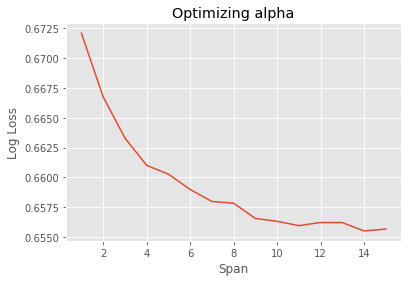

Our lowest log loss (0.655529) occurred at a span of 14


In [74]:
plt.style.use('ggplot')
plt.plot(list(range(1, 16)), (pd.Series(cv_scores)*-1)) # Plot our results

plt.title("Optimizing alpha")
plt.xlabel("Span")
plt.ylabel("Log Loss")
plt.show()

print("Our lowest log loss ({:2f}) occurred at a span of {}".format(best_score, best_span))

In [234]:
stats = df.copy()
stats_features = create_stats_features_ema(stats, span=14)
input_df = stats_features

In [235]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1002 entries, 2018-12-15-13-south-florida to 2018-11-06-20-wisconsin
Data columns (total 83 columns):
team                                      1002 non-null object
winner                                    1002 non-null object
HomeTeam                                  1002 non-null object
AwayTeam                                  1002 non-null object
date                                      1002 non-null object
game_index                                1002 non-null float64
home_points                               1002 non-null float64
away_points                               1002 non-null float64
away_assist_percentage                    944 non-null float64
away_assists                              944 non-null float64
away_block_percentage                     944 non-null float64
away_blocks                               944 non-null float64
away_defensive_rating                     944 non-null float64
away_defensive_rebound_percenta

In [236]:
input_df = input_df.dropna().drop_duplicates()

In [237]:
FIELDS_TO_DROP = ['away_points', 'home_points', 'winner','HomeTeam', 'AwayTeam','date','game_index','team']

In [238]:
X = input_df.drop(FIELDS_TO_DROP, 1).dropna().drop_duplicates()
y = input_df[['home_points', 'away_points']].values

In [239]:
print(X.shape)
print(y.shape)

(944, 75)
(944, 2)


In [240]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
parameters = {'bootstrap': False,
              'min_samples_leaf': 3,
              'n_estimators': 50,
              'min_samples_split': 10,
              'max_features': 'sqrt',
              'max_depth': 6}
model = RandomForestRegressor(**parameters)
model.fit(X_train, y_train)
print(model.predict(X_test).astype(int), y_test)

[[67 62]
 [72 65]
 [69 65]
 [77 70]
 [73 68]
 [78 67]
 [73 65]
 [74 68]
 [73 70]
 [70 63]
 [69 63]
 [69 64]
 [74 67]
 [70 65]
 [74 65]
 [77 68]
 [70 66]
 [67 63]
 [71 64]
 [69 64]
 [83 74]
 [66 62]
 [77 70]
 [76 71]
 [80 72]
 [73 69]
 [75 67]
 [73 66]
 [68 63]
 [69 65]
 [77 68]
 [72 65]
 [66 62]
 [76 67]
 [72 66]
 [69 63]
 [78 68]
 [71 65]
 [80 74]
 [81 71]
 [76 71]
 [75 65]
 [72 66]
 [75 69]
 [73 66]
 [71 65]
 [65 62]
 [70 65]
 [79 69]
 [75 67]
 [71 67]
 [73 69]
 [71 67]
 [72 65]
 [77 72]
 [72 67]
 [73 64]
 [70 64]
 [76 68]
 [68 61]
 [71 65]
 [79 69]
 [76 71]
 [75 68]
 [71 62]
 [81 72]
 [72 65]
 [70 64]
 [72 66]
 [71 64]
 [71 67]
 [66 63]
 [69 65]
 [72 65]
 [73 65]
 [74 68]
 [73 67]
 [74 67]
 [68 64]
 [69 63]
 [72 67]
 [68 62]
 [73 66]
 [68 64]
 [74 67]
 [82 74]
 [79 74]
 [77 67]
 [69 65]
 [69 64]
 [70 64]
 [77 68]
 [71 65]
 [68 63]
 [75 69]
 [75 65]
 [79 73]
 [68 62]
 [75 66]
 [70 66]
 [77 67]
 [78 68]
 [72 61]
 [71 66]
 [78 71]
 [69 62]
 [71 65]
 [69 65]
 [81 72]
 [69 64]
 [76 65]
 

In [241]:
preds = model.predict(X_test).astype(int)

In [242]:
test = pd.DataFrame(y_test,columns =['testH','testA'])
test2 = pd.DataFrame(preds,columns =['predH','predA'])

In [248]:
test['predH'] = test2['predH']
test['predA'] = test2['predA']

In [249]:
test

,testH,testA,predH,predA
0,64.0,54.0,67,62
1,73.0,60.0,72,65
2,44.0,67.0,69,65
3,63.0,87.0,77,70
4,74.0,72.0,73,68
...,...,...,...,...
231,74.0,71.0,77,62
232,52.0,70.0,71,67
233,61.0,75.0,69,64
234,60.0,72.0,78,71


In [250]:
test.to_csv(r'C:\Users\bdraus\Dropbox (Expedia Group)\Ben\Python\Betting Models\test.csv')